[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dessia-tech/tutorials/blob/datatools/notebook/datatools.ipynb)

# **Introduction**

# **Installation**

## Initialization (only for Colab users)

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user
!conda update conda -y

In [ ]:
# Reload the web page (quit) and execute this cell
import sys
print("User Current Version:-", sys.version)
if sys.version[:3] != "3.8":
  raise SystemError("Try to reload the web page (quit)")

User Current Version:- 3.8.1 (default, Jan  8 2020, 22:29:32) 
[GCC 7.3.0]


## Python imports

In [ ]:

!pip install dessia_common

/bin/bash: pip: command not found


In [ ]:
from dessia_common.core import DessiaObject, DessiaFilter, FiltersList
from dessia_common.models import all_cars_no_feat, all_cars_wi_feat, rand_data_middl
from dessia_common.datatools import HeterogeneousList, CategorizedList

ModuleNotFoundError: ignored

# **Heterogeneous Lists**

A HeterogeneousList is a container object for DessiaObjetcs.

It implements many features that can help engineers exploring data contained in a list. HeterogenenousList includes, among others, a plot_data method, filtering capabilities, data exploration features and can be clustered into a CategorizedList to help clustering similar data.

The current section is a guide for users to prepare data for HeterogeneousList and easy manipulate them once created.

## Description

HeterogeneousList is a class object that inherits from DessiaObject. Thus, any method developed for DessiaObject will work on HeterogeneousList.

It is designed to store a list of any kind of DessiaObjects, potentially from different classes, in a same HeterogeneousList.

Every subclass of DessiaObject can be stored in a HeterogeneousList which possesses only one additional attribute and two properties:
*   *dessia_objects* (attribute): list of DessiaObjects, the data to store and study
*   *common_attributes* (property): common attributes in stored DessiaObjects. Can be defined by user or automatically generated
*   *matrix* (property): matrix of data, $n_{samples} \times n_{features}$


In [ ]:
# Don't run this code
class HeterogeneousList(DessiaObject):
    _standalone_in_db = True
    _vector_features = ["name", "common_attributes"]

    def __init__(self, dessia_objects: List[DessiaObject] = None, name: str = ''):
        if dessia_objects is None:
            dessia_objects = []
        self.dessia_objects = dessia_objects
        DessiaObject.__init__(self, name=name)

    @property
    def common_attributes(self):
      return

    @property
    def matrix(self):
      return

### *dessia_objects*
*dessia_objects* is the list of stored data to study in HeterogeneousList.

### *common_attributes*
By default, *common_attributes* are computed automatically. They are the common numerical attributes between all classes of DessiaObjects in *dessia_objects*. These attributes must be arguments of ```__init__``` method and not standard *DessiaObject* attributes:

```
for arg in args(init):
    if isnumeric(arg) and arg not in attributes(DessiaObject) and arg in all(DessiaObjects):
        common_attributes <- arg
```

This behavior can be customed with `_vector_features` class attributes.

### *matrix*
The property *matrix* is computed with the *common_attributes* and the *to_vector* method of DessiaObjects present in *dessia_objects*.

It is the concatenation of all equivalent vectors of each DessiaObject stored in *dessia_objects*. 

These vectors are computed with the customable *to_vector* method of each DessiaObject. In HeterogeneousList, only dimensions present in *common_attributes* are kept for building the vector. 

Columns of *matrix* are stored in the same order as *common_attributes*.

In [ ]:
# Don't run this code
@property
def matrix(self):
    if self._matrix is None:
        matrix = []
        for dessia_object in self.dessia_objects:
            temp_row = dessia_object.to_vector()
            vector_features = dessia_object.vector_features()
            matrix.append(list(temp_row[vector_features.index(attr)] for attr in self.common_attributes))
        self._matrix = matrix
    return self._matrix

## Create a HeterogeneousList
A HeterogeneousList is created from a list of DessiaObjects and a name (optional).

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList
class MyObject(DessiaObject):
  def __init__(self, attr: int, name=''):
    self.attr = attr

my_list = [MyObject(idx) for idx in range(1000)]
my_hlist = HeterogeneousList(my_list, 'example')
print(my_hlist)

## Custom *common_attributes* and *matrix* computation
The list of common attributes generated with standard behavior can be too restrictive. Indeed, sometimes, attributes are not called in `__init__` method but just computed in its script. 

Furthermore, some attributes may not be directly attached to the DessiaObjects to vectorize but to some subobject or a list of data, outside the scope of objects contained in *dessia_objects*. 

To handle such cases, one can respectively modify the class attribute *_vector_features* or the method *to_vector* in the mother classes of instances stored in *dessia_objects*.



### Class attribute *_vector_features*
To specify attributes to compute vectors of DessiaObjects stored in *dessia_objects*, define a *_vector_features* class attribute in objects stored in *dessia_objects*.

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList
class MyObject(DessiaObject):
  _vector_features = ['attr', 'prop', 'not_in_init']
  def __init__(self, attr, name=''):
    self.attr = attr
    self.not_in_init = 1.5*attr
    DessiaObject.__init__(self, name=name)

  @property
  def prop(self):
    return 4
  
hlist = HeterogeneousList([MyObject(2.3), MyObject(-2), MyObject(25)])
print(hlist.common_attributes)

### Method *to_vector*
Computed values that are not directly DessiaObject attributes can be handled in HeterogeneousList by specifying them in `_vector_features` and customizing the `to_vector` method.
Attributes specified in `_vector_features` must be in the same order as values stored with the `to_vector` method.

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList
class MyObject(DessiaObject):
  _vector_features = ['attr', 'prop', 'not_in_init', 'in_to_vector']
  def __init__(self, attr, name=''):
    self.attr = attr
    self.not_in_init = 1.5*attr
    DessiaObject.__init__(self, name=name)

  @property
  def prop(self):
    return 4

  def to_vector(self):
    return [self.attr, self.not_in_init, self.prop, self.attr*124]
  
hlist = HeterogeneousList([MyObject(2.3), MyObject(-2), MyObject(25)])
print(hlist.common_attributes)

## Work with HeterogeneousList
HeterogeneousList are designed to facilitate list handling in Dessia workflows, both on platform and in IDEs (local). In that sense, they have customed built-in methods and additional methods to facilitate access to data and measurements.

**Built-in methods:**
*   [`__len__`](https://lien vers la doc)
*   [`__str__`](https://lien vers la doc)
*   [`__getitem__`](https://lien vers la doc)
*   [`__add__`](https://lien vers la doc)
*   [`extend`](https://lien vers la doc)

**Implemented methods:**
*   [`get_attribute_values`](https://lien vers la doc)
*   [`get_column_values`](https://lien vers la doc)
*   [`sort`](https://lien vers la doc)
*   [`mean`](https://lien vers la doc)
*   [`standard_deviation`](https://lien vers la doc)
*   [`variances`](https://lien vers la doc)
*   [`covariance_matrix`](https://lien vers la doc)
*   [`distance_matrix`](https://lien vers la doc)
*   [`filtering`](https://lien vers la doc)
*   [`plot`](https://lien vers la doc)
*   [`pareto_indexes`](https://lien vers la doc)
*   [`pareto_points`](https://lien vers la doc)
*   [`pareto_sheets`](https://lien vers la doc)
*   [`singular_values`](https://lien vers la doc)

## Inherit from HeterogeneousList
HeterogeneousList is a base class to sustain engineers in handling lists of DessiaObjects. It can be used as a parent class to inherit from, in order to use all its standard methods in addition to specific customed methods, attached to its child. 

This can be particularly useful when some standard methods do not work as expected for a special case.


In [ ]:
from typing import List
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList

class MyObject(DessiaObject):
    _vector_features = ['attr']
    def __init__(self, attr, name=''):
        self.attr = attr
        DessiaObject.__init__(self, name=name)

class MyHList(HeterogeneousList):
    def __init__(self, dessia_objects: List[MyObject], other_attr, name=''):
        HeterogeneousList.__init__(self, dessia_objects, name)
        self.other_attr = other_attr

    def my_method(self):
        print("This is a customed method")

    def __str__(self):
        string = HeterogeneousList.__str__(self)
        list_string = string.split('\n')
        list_string[0] += f', list attr = {self.other_attr}'
        return '\n'.join(list_string)

my_hlist = MyHList([MyObject(2.3), MyObject(-2), MyObject(25)], 42, 'name')
my_hlist.my_method()
print(my_hlist)

# **Categorized Lists for clustering**
A Categorized List is a container object for clustered DessiaObjetcs.

It implements many features that can help engineers to explore clusters in data.
CategorizedList includes, among others, a plot_data method, user friendly clusters manipulation and metrics.

The current section is a guide for users to prepare data for CategorizedList and easy manipulate them once created.

## Description
CategorizedList is a class object that inherits from HeterogeneousList. Thus, any method developed for HeterogeneousList will work on CategorizedList, except for `__add__` and `extend` which behavior would not be consistent for clustered data. Indeed, merging two CategorizedList into one with no new computation of labels does not mean anything in terms of data.

It is designed to labelize data in a HeterogeneousList.

Thus, it has the same attributes and properties as HeterogeneousList plus an attribute and a property:
*   *labels* (attribute): list of `int`, list of labels matching with *dessia_objects*
*   *n_clusters* (property): `int`, number of clusters in CategorizedList. 

**WARNING: Outliers stored in label `-1` are not considered as a cluster.**

## Create a CategorizedList
A CategorizedList must be created with a clustering ClassMethod, in order to fill the *labels* attribute with labels computed with a clustering method.

In [ ]:
from dessia_common.core import DessiaObject
from dessia_common.datatools import HeterogeneousList, CategorizedList
class MyObject(DessiaObject):
  def __init__(self, attr: int, name=''):
    self.attr = attr

my_list = [MyObject(idx) for idx in range(1000)]
my_hlist = HeterogeneousList(my_list, 'example')
my_clist = CategorizedList.from_kmeans(my_hlist, n_clusters=10)
print(my_clist)

## Work with CategorizedList
CategorizedList are designed to facilitate clustering generation and manipulation, both on platform and in IDEs (local). In that sense, they have methods to facilitate access to data, clusters manipulations and measures.

**Clustering methods:**
*   [`from_agglomerative_clustering`](https://lien vers la doc): Compute Agglomerative Clustering.
*   [`from_dbscan`](https://lien vers la doc): Compute DBSCAN clustering.
*   [`from_kmeans`](https://lien vers la doc): Compute KMeans clustering.
*   [`from_pareto_sheets`](https://lien vers la doc): Compute successive pareto sheets and put it in clusters.

**Implemented methods:**
*   [`clustered_sublists`](https://lien vers la doc): Split a CategorizedList of labelled DessiaObjects into a CategorizedList of labelled HeterogeneousLists.
*   [`cluster_distances`](https://lien vers la doc): Computes all distances between elements of each cluster and their mean
*   [`mean_clusters`](https://lien vers la doc): Compute mathematical means of all clusters
*   [`cluster_real_centroids`](https://lien vers la doc): In each cluster, finds the nearest existing element from the cluster’s mean.

# **Tutorial 1: Visualize data with HeterogeneousList**
This tutorial describes the method to create a HeterogeneousList from a list of data and plot it in a web browser.

It also details the procedure to create the equivalent workflow to be stored and ran on Dessia platform.

## Build list of data
HeterogeneousList are useful for handling list of DessiaObjects. First, import packages and create a DessiaObject class.

In [ ]:
import pkg_resources
import numpy as npy

from dessia_common import DessiaObject
from dessia_common.datatools import HeterogeneousList
import dessia_common.typings as dct
from dessia_common.files import StringFile

# Class definition
class Car(DessiaObject):
    _standalone_in_db = True
    _non_data_hash_attributes = ['name']
    _vector_features = ['mpg', 'displacement', 'horsepower', 'weight', 'thrust', 'price'] # Important parameter

    def __init__(self, name: str, mpg: float, cylinders: int, displacement: dct.Distance, horsepower: float,
                 weight: dct.Mass, acceleration: dct.Time, model: int, origin: str):
        DessiaObject.__init__(self, name=name)
        self.mpg = mpg
        self.cylinders = cylinders
        self.displacement = displacement
        self.horsepower = horsepower
        if horsepower == 0: # Avoid 0 horsepower
            self.horsepower = 50.
        self.weight = weight*0.453592 # convert in kg
        self.acceleration = acceleration
        self.model = model
        self.origin = origin

    @classmethod
    def from_csv(cls, file: StringFile, end: int = None, remove_duplicates: bool = False):
        """
        Generates Cars from given .csv file.
        """
        array = [row.split(',') for row in file.getvalue().split('\n')][1:-1]
        cars = []
        for idx_line, line in enumerate(array):
            if end is not None and idx_line >= end:
                break
            if not remove_duplicates or (remove_duplicates and line.tolist() not in cars):
                attr_list = [float(attr) if attr.replace('.', '').isnumeric() else attr for attr in line]
                attr_list[3] /= 1000 # convert displacement in m
    
                for idx_attr, attr in enumerate(attr_list): # replace numpy types
                    if isinstance(attr, npy.int64):
                        attr_list[idx_attr] = int(attr)
                    elif isinstance(attr, npy.float64):
                        attr_list[idx_attr] = float(attr)
                cars.append(cls(*attr_list))
        return cars
        
    @property
    def thrust(self):
      return self.weight*100/self.acceleration/1.609 # dummy example, convert in km
      
    def to_vector(self):
      return [self.mpg, self.displacement, self.horsepower, self.weight, self.thrust,
              self.weight*5*self.horsepower/150] # price is a dummy example

## Store data in HeterogeneousList

In [ ]:
# Import data in a list
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream = StringFile.from_stream(csv_cars)
list_mycars = Car.from_csv(stream)

# Create HeterogeneousList of cars
my_hlist = HeterogeneousList(list_mycars)

## Plot HeterogeneousList
To visualize data stored in HeterogeneousList, use the plot method.

It displays numerical data stored in matrix with a parallel plot, a scatter matrix and a dimensionality plot.

In [ ]:
# Plot my_hlist
my_hlist.plot()

### Parallel plot of data
Shows attributes values on parallel axes.

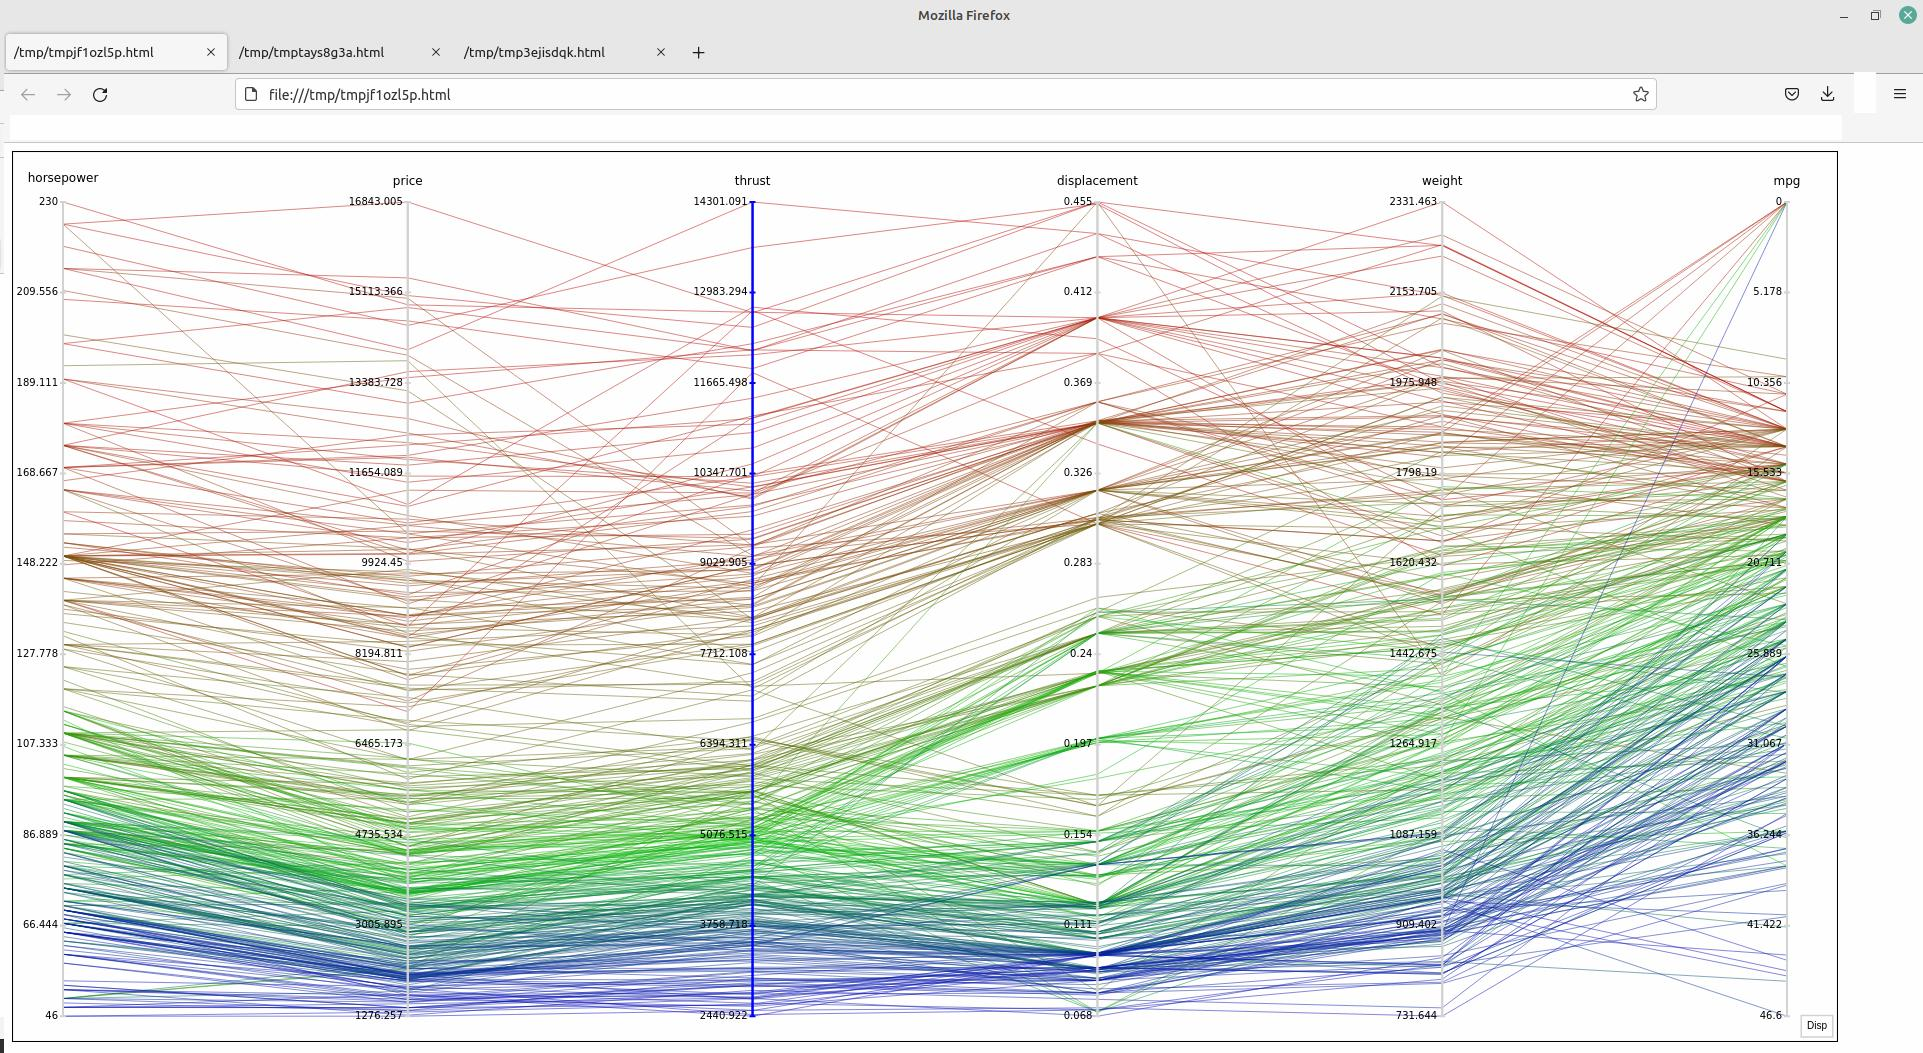

### Scatter matrix of data
Plots all pairwise attributes in scatters so that correlations can be seen.

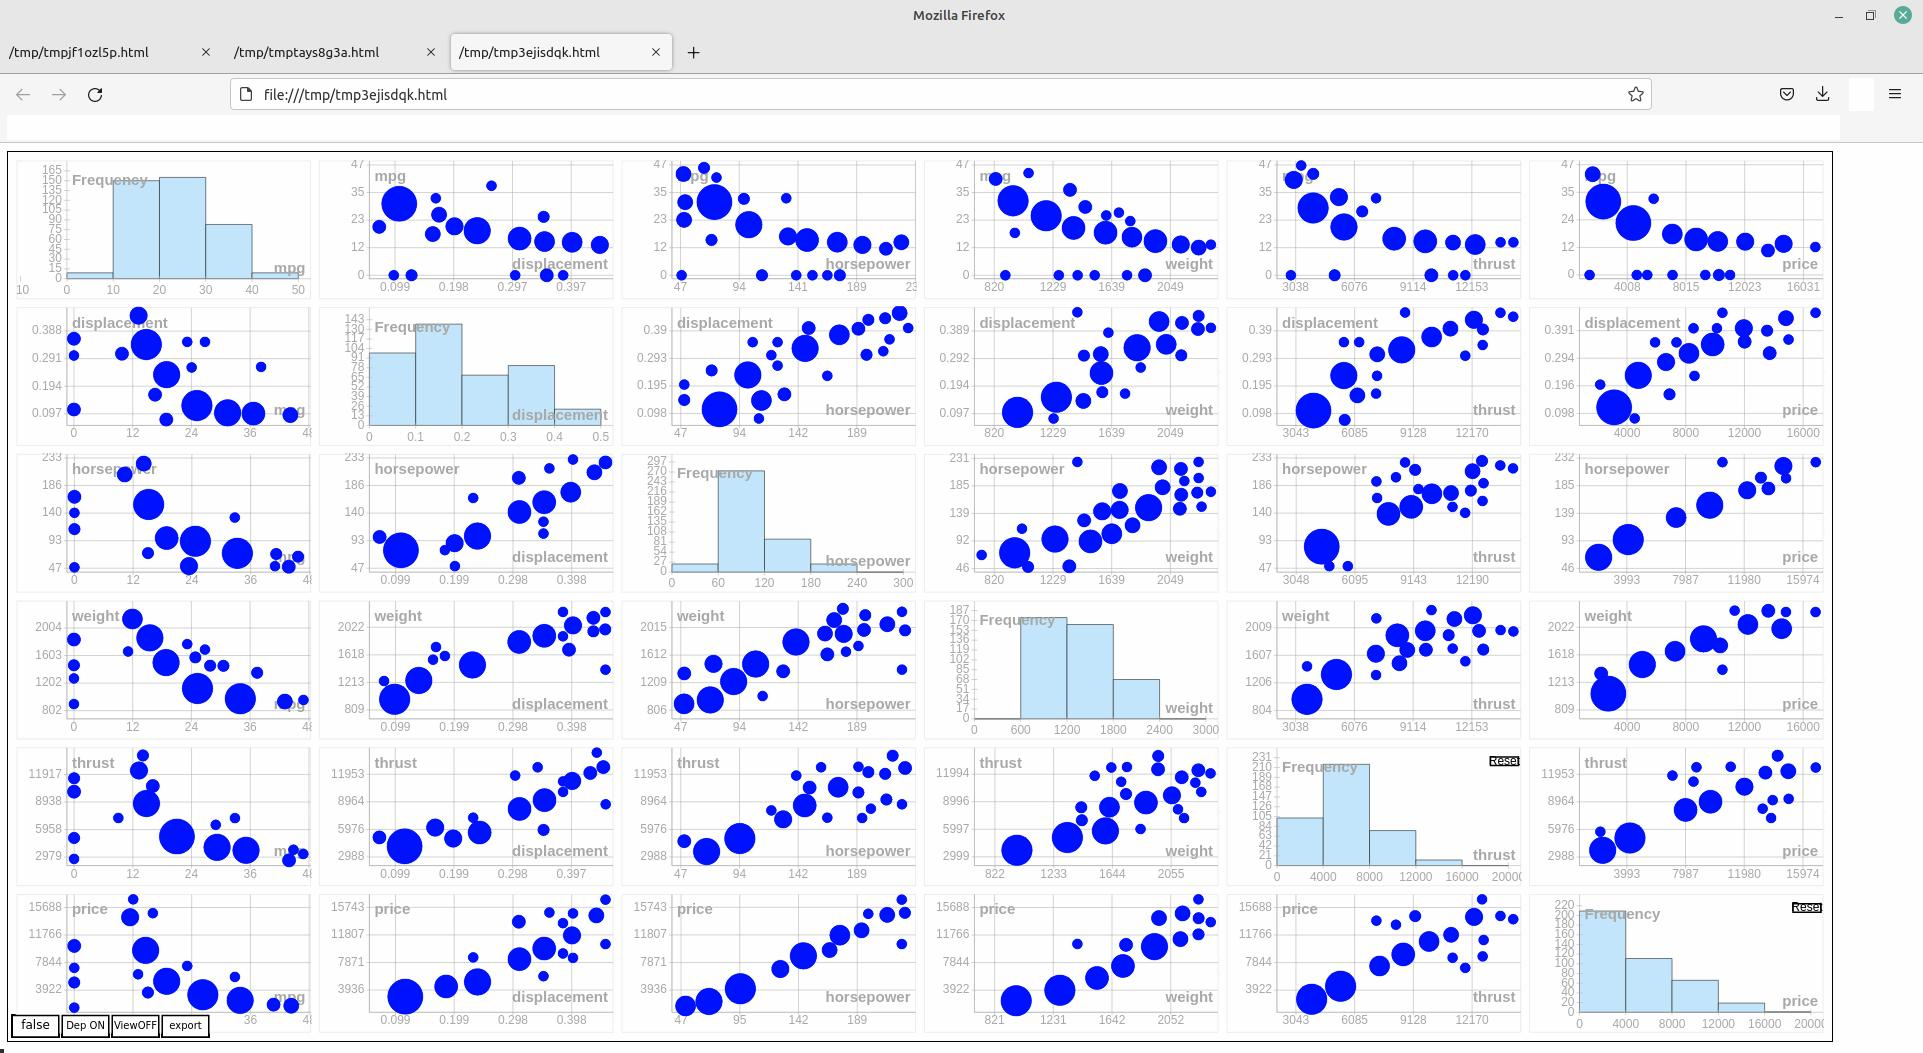

### Dimensionality plot
Plots normalized singular values in a logarithmic diagram. This diagram can be used to highlight the real dimensionality of data which is often lower than the number of considered features. In this case, real dimensionality of data is the same as the number of features.

In general, dimensionality of data is equal to the rank of their matrix.

For more information, see [the singular values documention](https://faire lien).

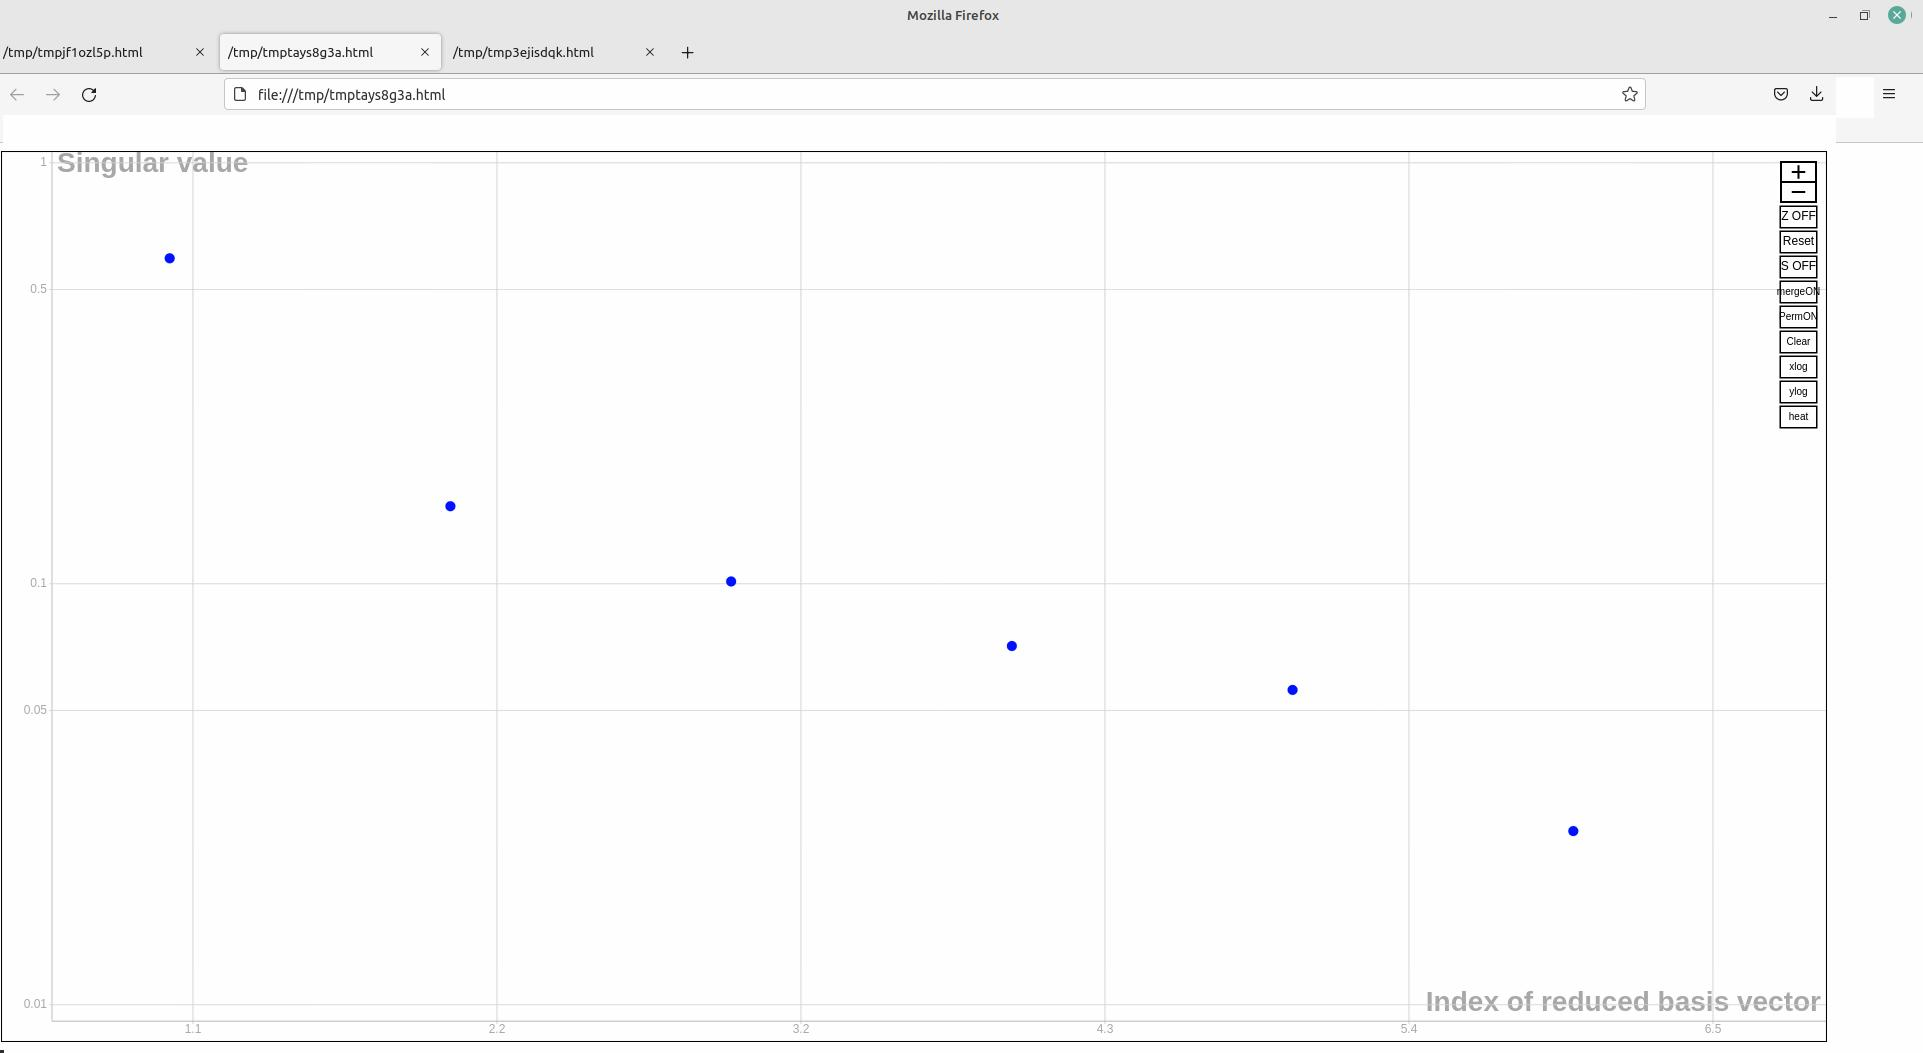

## Build equivalent workflow
The previous process can be instantiated in a workflow and ran on platform. For the sake of simplicity, the `Car` class used in what follows is the standard one available in `dessia_common.tests`, present in the platform database. 

Firstly, import the csv file of all available cars, write the following code:

In [ ]:
import pkg_resources

# Import file
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream_file = StringFile.from_stream(csv_cars)

Then, write the code to create the required workflow blocks: 

1.   One `ClassMethod` block for loading cars in a list
2.   One `InstantiateModel` block for pushing the list of cars as `dessia_objects` in a new HeterogeneousList

Link them with a pipe and create the corresponding workflow.




In [ ]:
from dessia_common.typings import ClassMethodType
from dessia_common.workflow.blocks import ClassMethod, InstantiateModel
from dessia_common.workflow.core import Workflow, Pipe

# Create blocks
load_car_block = ClassMethod(method_type=ClassMethodType(Car, 'from_csv'), name='CSV Cars')
hlist_block = InstantiateModel(model_class=HeterogeneousList, name='HList Cars')
blocks = [load_car_block, hlist_block]

# Create pipe
pipe = Pipe(load_car_block.outputs[0], hlist_block.inputs[0])

# Create workflow
workflow = Workflow(blocks, [pipe], output=hlist_block.outputs[0], name='Demo HList')

Check the generated workflow by running `workflow.plot()`:

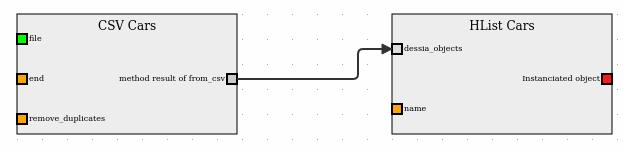


## Run workflow
Once the workflow is created, it can be ran and its results can be plotted in web browser. To do so, write the following lines:

In [ ]:
# Run workflow
workflow_run = workflow.run({workflow.index(load_car_block.inputs[0]): stream_file})

# Plot results (not shown in tutorial for lightness, the same as previous one)
workflow_run.output_value.plot()

## Build and run workflow on platform
This workflow can be built in the workflow builder of platform with the following procedure.

#### 1. Create a block to import Cars
ClassMethod > dessia_common > tests > Car


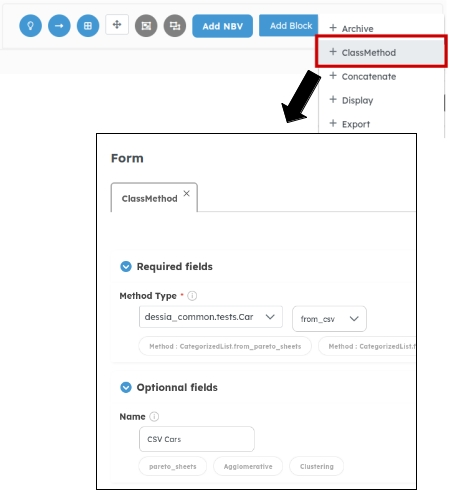

#### 2. Create a block to make HeterogeneousList
InstantiateModel > dessia_common > datatools > HeterogeneousList

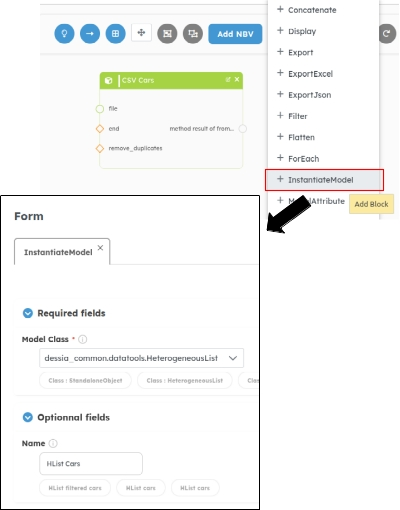

#### 3. Finish the workflow
1.   Link the two blocks 
2.   Double-click on output of block HList Cars
3.   Save the workflow

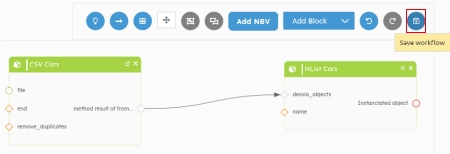

#### 4. Run workflow and see results

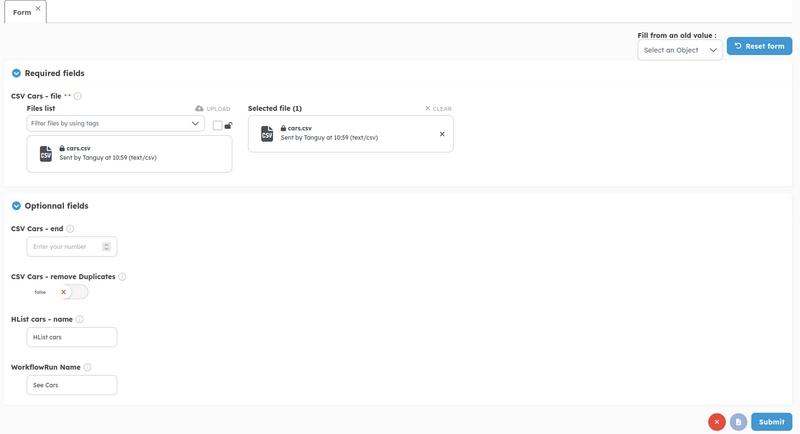

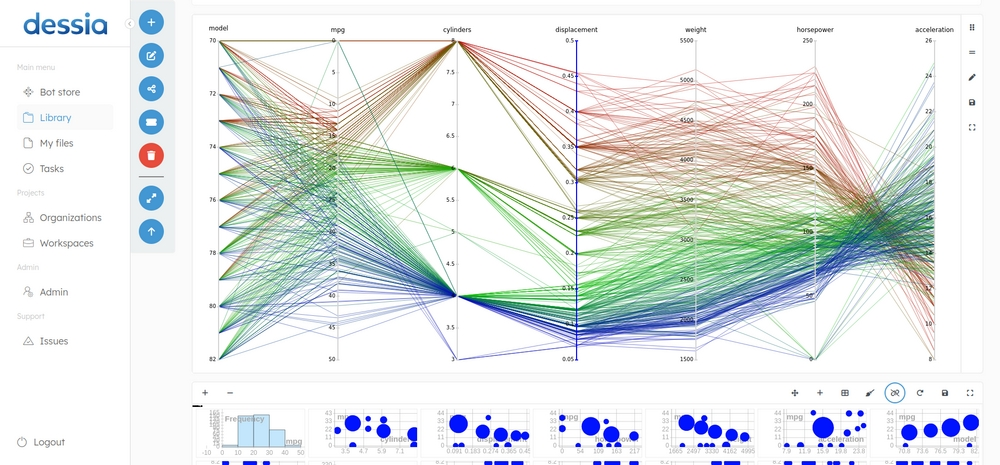

# **Tutorial 2: Clustering on HeterogeneousList**
This tutorial describes how to cluster data in a CategorizedList from a HeterogeneousList.


## Store data in a HeterogeneousList

In [ ]:
import pkg_resources
from dessia_common.datatools import HeterogeneousList
from dessia_common.files import StringFile

# Import data in a list
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream = StringFile.from_stream(csv_cars)
list_mycars = Car.from_csv(stream)

# Create HeterogeneousList of cars
my_hlist = HeterogeneousList(list_mycars)

## Build a CategorizedList with a clustering method

In order to cluster elements stored in *dessia_objects* of HeterogeneousList:
1.   Choose a clustering class method in class CategorizedList from available methods.
2.   Set its hyperparameters
3.   Run your script

The documentation for clustering is available [here](https://faire lien).

In [ ]:
from dessia_common.datatools import CategorizedList

# Now, three types of clustering
cars_dbscan = CategorizedList.from_dbscan(my_hlist, eps=40, min_samples=5, mink_power=2, 
                                          leaf_size=30, metric="euclidean", scaling=False, name="")

cars_kmeans = CategorizedList.kmeans(my_hlist, n_clusters=10, n_init=10, tol=1e-4, scaling=False, name="")

cars_agglomerative = CategorizedList.from_agglomerative_clustering(my_hlist, n_clusters=10, affinity='euclidean', 
                                                                   linkage='ward', distance_threshold=None, scaling=False, 
                                                                   name="")

## Vizualise clusters

To see how data are clustered, plot the CategorizedList. Plots are the same as HeterogeneousList's ones but the scatter matrix is coloured with clusters.

In [ ]:
# Plot
cars_dbscan.plot()

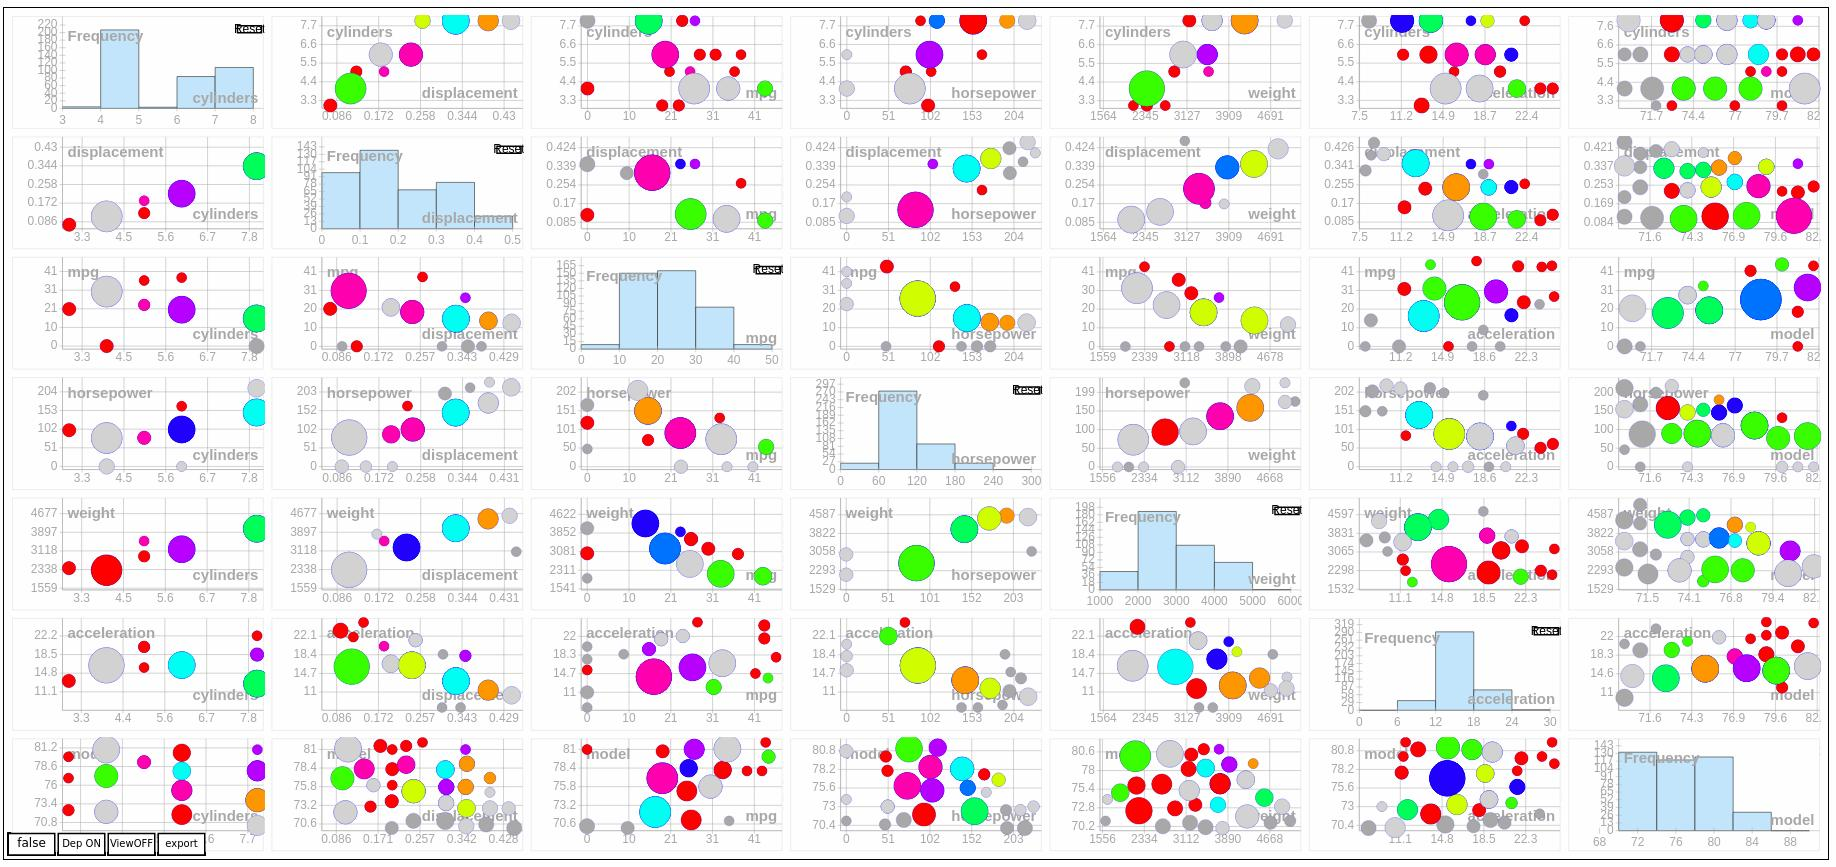

## Build equivalent workflow

Like HeterogeneousList, CategorizedList can be created in workflows, that can be created on platform.

### Create a HeterogeneousList workflow

For the sake of simplicity, the previous HeterogeneousList workflow is used to initiate the further workflow. 

In [ ]:
import pkg_resources
from dessia_common.typings import ClassMethodType
from dessia_common.workflow.blocks import ClassMethod, InstantiateModel
from dessia_common.workflow.core import Workflow, Pipe

# Import file
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream_file = StringFile.from_stream(csv_cars)

# Create blocks
load_car_block = ClassMethod(method_type=ClassMethodType(Car, 'from_csv'), name='CSV Cars')
hlist_block = InstantiateModel(model_class=HeterogeneousList, name='HList Cars')

### Add a clustering block

But a ClassMethod block is added to the current workflow.

In [ ]:
# Add clustering block (ClassMethod)
cluster_block = ClassMethod(method_type=ClassMethodType(CategorizedList, 'from_agglomerative_clustering'), name='Clustering')

# Create blocks
blocks = [load_car_block, hlist_block, cluster_block]

# Create pipe
pipe_0 = Pipe(load_car_block.outputs[0], hlist_block.inputs[0])
pipe_1 = Pipe(hlist_block.outputs[0], cluster_block.inputs[0])
pipes = [pipe_0, pipe_1]

# Create workflow
workflow = Workflow(blocks, pipes, output=cluster_block.outputs[0], name='Demo HList')

# Control workflow
workflow.plot()

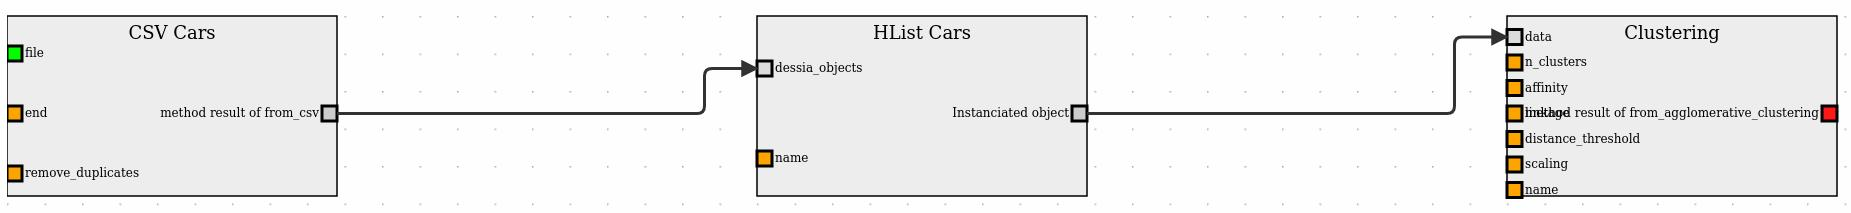

### Run workflow

Set *workflow_run* to run workflow

In [ ]:
# Run workflow
workflow_run = workflow.run({workflow.index(load_car_block.inputs[0]): stream_file,
                             workflow.index(cluster_block.inputs[1]): 10})

# Plot results (not shown in tutorial for lightness, the same as previous one)
workflow_run.output_value.plot()

## Build and run workflow on platform

This workflow can be built in the workflow builder of platform with the following procedure. It is the same as the [tutorial 1's one](https://colab.research.google.com/github/Dessia-tech/tutorials/blob/datatools/notebook/datatools.ipynb#scrollTo=zeorVpnQQC3b&line=2&uniqifier=1) but with an additional block for clustering.

#### 1. Add the clustering block
Add a new ClassMethod block and choose the clustering method dessia_common.datatools.CategorizedList

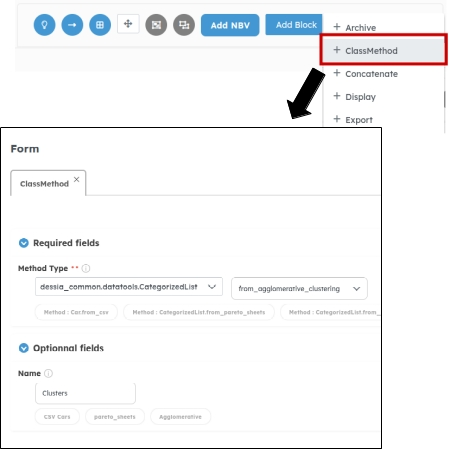

#### 2. Run workflow and see results

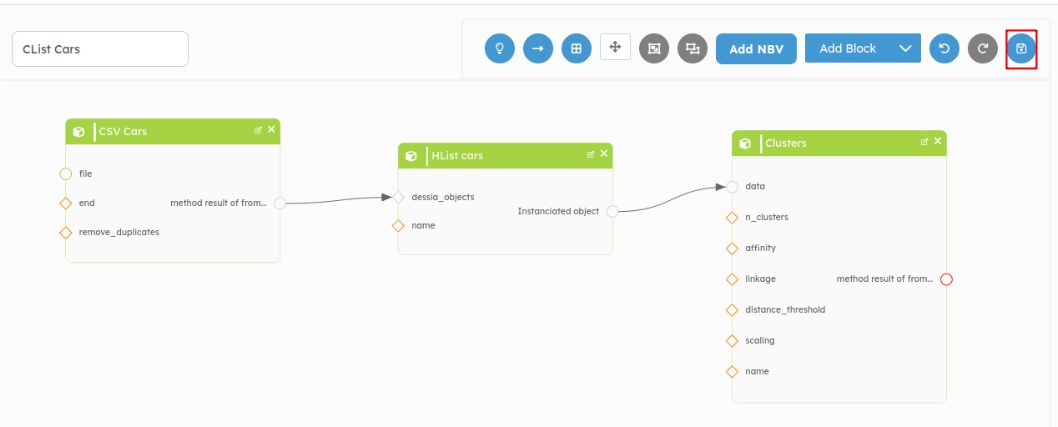

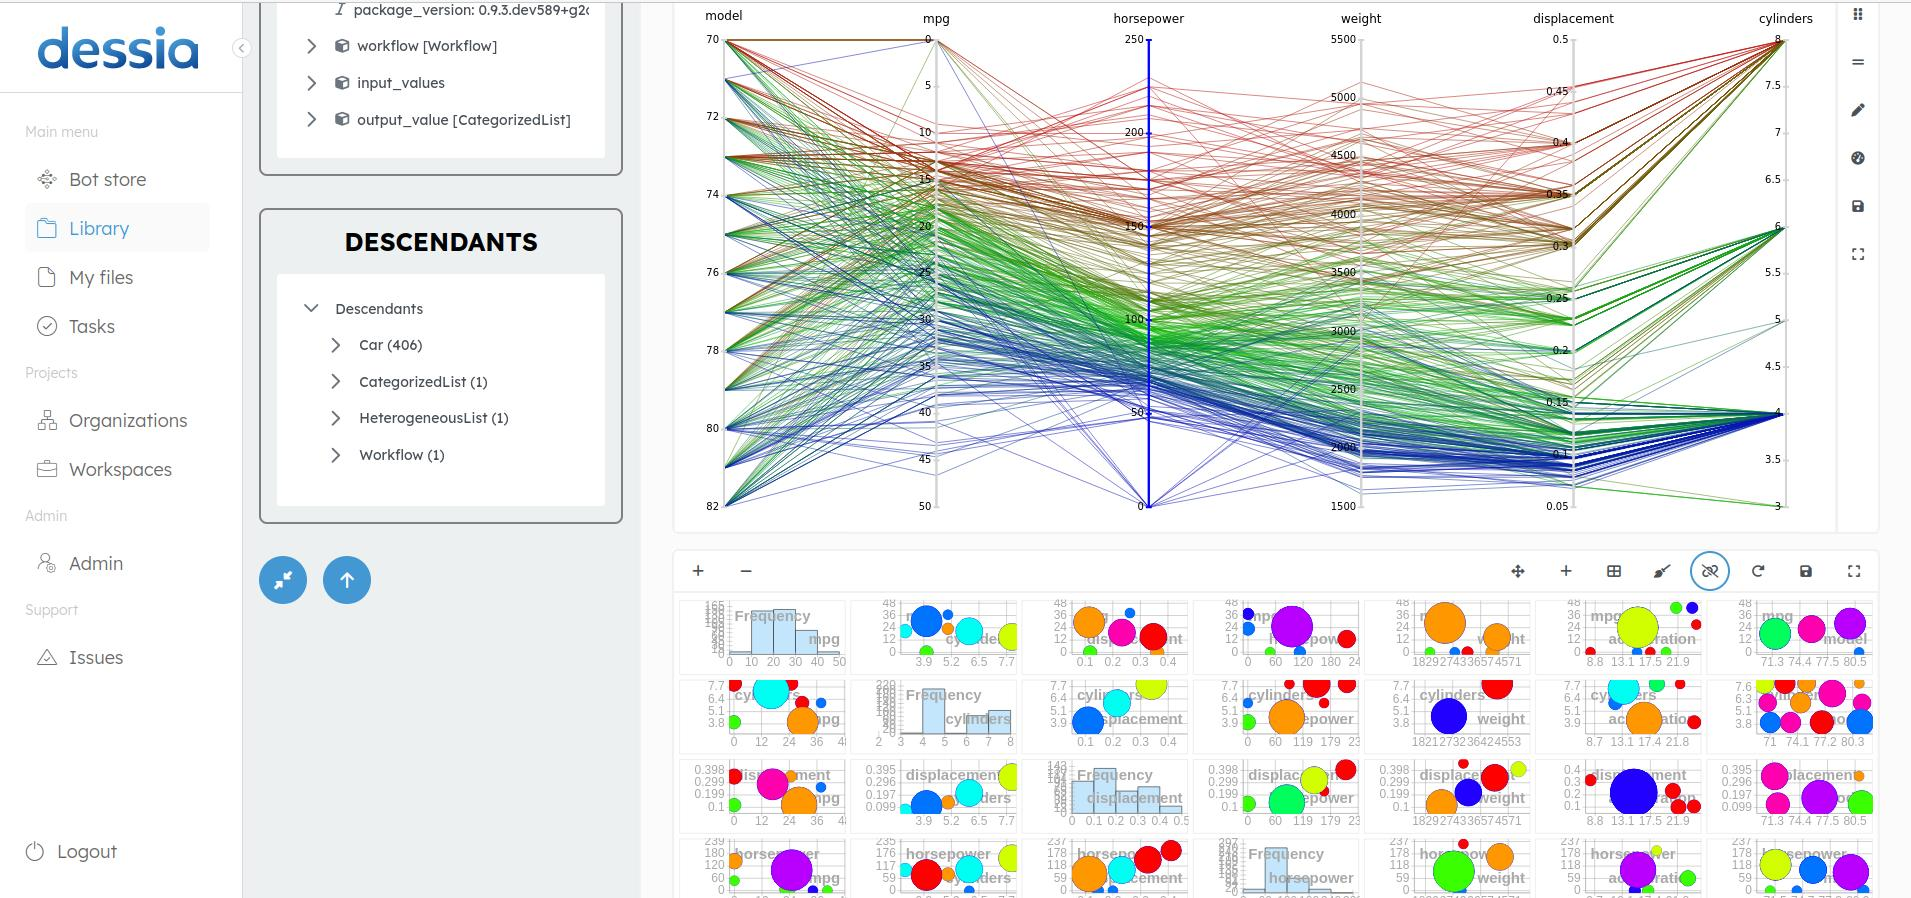

### **Tutorial 3: Metrics on data**

## Store data in a HeterogeneousList

In [ ]:
import pkg_resources
from dessia_common.datatools import HeterogeneousList
from dessia_common.files import StringFile

# Import data in a list
csv_cars = pkg_resources.resource_stream('dessia_common', 'models/data/cars.csv')
stream = StringFile.from_stream(csv_cars)
list_mycars = Car.from_csv(stream)

# Create HeterogeneousList of cars
my_hlist = HeterogeneousList(list_mycars)

# **Tutorial 4: Pareto selection**

# **Tutorial 5: Centroids in clusters**

In [ ]:
reductor = script_optimize()

# Jupyter Notebook usage
reductor.save_babylonjs_to_file(filename='/tmp/reductor3d')
HTML(filename='/tmp/reductor3d.html')